In [ ]:
pip install catboost optuna shap phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import phik as p

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, make_scorer, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, cv as cb_cross_val, Pool
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler
import shap

from joblib import parallel_backend

import tqdm
import time

import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
simplefilter("ignore", category=RuntimeWarning)

# constants

In [ ]:
SEED = 42
SAVE_PATH = '/content/drive/MyDrive/HSE_PSB_hack/'
gpu = False
cv = cv = StratifiedGroupKFold(5, shuffle=True)

# features

In [ ]:
cat_cols = [
    'rooms',
    'payment_method',
    'nights',
    'source',
    'room_type',
    'guests',
    'hotel'
]

train_cat_col = 'reservation_status'

num_cols = [
    'cost',
    'prepayment'
]

date_cols = [
    'booking_date',
    'check_in',
    'check_out',
    'cancel_date'
]


group_col = 'reservation_id'

target_col = 'target'

new_cat_cols = ['hotel',
                'rooms_q',
                'nights_q',
                'guests_q',
                'cost_q',
                'prepayment_q',
                'source_d',
                'payment_method_d',
                'room_price_per_night_q',
                'prepayment_ratio_q',
                'booking_to_check_in_days_q',
                'stay_duration_q',
                'room_type_0',
                'room_type_1',
                'room_type_2',
                'room_type_3',
                'room_type_4',
                'room_type_5',
                'room_type_6',
                'booking_date_month',
                'booking_date_week',
                'booking_date_time_of_day',
                'check_in_month',
                'check_in_week',
                'check_in_time_of_day',
                'check_out_month',
                'check_out_week',
                'check_out_time_of_day',
                'check_in_time_of_day_morning',
                'is_peak_season',
                ]

new_num_cols = ['room_price_per_night',
                'prepayment_ratio',
                'booking_to_check_in_days',
                'stay_duration',
                'price_per_person_per_night',
                'rooms_per_guest',
                'deposit_discount',
                'prepayment_per_night',
                'cost_div_hotel',
                'booking_date_arcsin',
                'booking_date_diff_arcsin',
                'tavg_25_days_ago',
                'tmin_25_days_ago',
                'tmax_25_days_ago',
                'prcp_25_days_ago',
                'wdir_25_days_ago',
                'wspd_25_days_ago',
                'pres_25_days_ago',
                'source_stay_duration',
                'prepayment_bookings',
                'payment_method_avg_price',
                'prepayment_normalized_stay',
                'source_cost_ratio',
                'combined_indicators',
                'cancel_hotel_room_type']

# data import


In [ ]:
df_train = pd.read_excel('/content/drive/MyDrive/HSE_PSB_hack/train.xlsx')
df_test = pd.read_excel('/content/drive/MyDrive/HSE_PSB_hack/test.xlsx')

# data analysis

In [ ]:
df_train.head(3)

,Unnamed: 0,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4


In [ ]:
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True);

In [ ]:
new_cols = {'№ брони': 'reservation_id',
 'Номеров': 'rooms',
 'Стоимость': 'cost',
 'Внесена предоплата': 'prepayment',
 'Способ оплаты': 'payment_method',
 'Дата бронирования': 'booking_date',
 'Дата отмены': 'cancel_date',
 'Заезд': 'check_in',
 'Ночей': 'nights',
 'Выезд': 'check_out',
 'Источник': 'source',
 'Статус брони': 'reservation_status',
 'Категория номера': 'room_type',
 'Гостей': 'guests',
 'Гостиница': 'hotel'}

In [ ]:
df_train.rename(columns=new_cols, inplace=True)
df_test.rename(columns=new_cols, inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   reservation_id      26174 non-null  object        
 1   rooms               26174 non-null  int64         
 2   cost                26174 non-null  float64       
 3   prepayment          26174 non-null  int64         
 4   payment_method      26174 non-null  object        
 5   booking_date        26174 non-null  datetime64[ns]
 6   cancel_date         5192 non-null   datetime64[ns]
 7   check_in            26174 non-null  datetime64[ns]
 8   nights              26174 non-null  int64         
 9   check_out           26174 non-null  datetime64[ns]
 10  source              26174 non-null  object        
 11  reservation_status  26174 non-null  object        
 12  room_type           26174 non-null  object        
 13  guests              26174 non-null  int64     

# feature engineering

## decoding

In [ ]:
for cat_col in cat_cols:
  train_cols = df_train[cat_col].unique()
  test_cols = df_test[cat_col].unique()

  if set(train_cols) >= set(test_cols):
    print(True, cat_col)
  else:
    print(False,cat_col, train_cols, test_cols)

False rooms [1 2 3 4 5 6] [1 2 4 3 5 9]
True payment_method
False nights [ 3  2  1  4  5  6  8 10  7  9 11 13 12 31 14 16 15 26 18 20 17 21] [ 2  1  3  5  4  8  6  7  9 10 11 19 12 13 14 17 20]
True source
False room_type ['Номер «Стандарт»' 'Номер «Студия»' 'Номер «Люкс»'
 'Апартаменты с 2 спальнями с отдельным входом' 'Коттедж с 3 спальнями'
 '1. Апартаменты с 2 спальнями с отдельным входом\n2. Апартаменты с 2 спальнями с отдельным входом'
 '1. Коттедж с 3 спальнями\n2. Коттедж с 3 спальнями'
 'Коттедж с 2 спальнями' '1. Номер «Стандарт»\n2. Номер «Стандарт»'
 '1. Номер «Стандарт»\n2. Номер «Стандарт»\n3. Номер «Стандарт»'
 'Номер «Стандарт» для маломобильных групп населения'
 '1. Номер «Люкс»\n2. Номер «Люкс»' '1. Номер «Стандарт»\n2. Номер «Люкс»'
 '1. Коттедж с 2 спальнями\n2. Коттедж с 2 спальнями\n3. Коттедж с 2 спальнями'
 '1. Коттедж с 2 спальнями\n2. Коттедж с 2 спальнями'
 '1. Номер «Стандарт»\n2. Номер «Стандарт»\n3. Номер «Стандарт»\n4. Номер «Стандарт» для маломобильных г

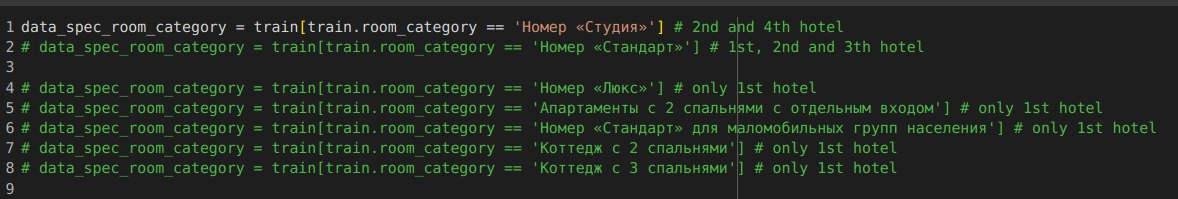

### q features

In [ ]:
cat_cols_label_encoder = [
    'rooms',
    'nights',
    'room_type',
    'guests'
    ]

In [ ]:
class QuantileBinner:
    def __init__(self, num_quantiles):
        self.num_quantiles = num_quantiles
        self.quantiles = None

    def fit_transform(self, column):
        self.quantiles = np.percentile(column, np.linspace(0, 100, self.num_quantiles + 1))

        quantile_indices = np.digitize(column, self.quantiles) - 1

        return quantile_indices

    def transform(self, column):
        if self.quantiles is None:
            raise ValueError("The model has not been fitted yet. Please call 'fit_transform' first.")

        quantile_indices = np.digitize(column, self.quantiles) - 1

        return quantile_indices

In [ ]:
for col in ['rooms', 'nights', 'guests'] + num_cols:
  quantile_binner = QuantileBinner(num_quantiles=4)
  df_train[col + '_q'] = quantile_binner.fit_transform(df_train[col])
  df_test[col + '_q'] = quantile_binner.transform(df_test[col])

### target decoding

In [ ]:
df_train[target_col] = (~df_train[target_col].isna()).astype(int)

### cat cols decoding

In [ ]:
def decode_feature_dct(data):
  unique_features = data.unique()
  return {key: value for key, value in zip(unique_features, range(len(unique_features)))}

In [ ]:
for col in ['source', 'payment_method']:
  dct = decode_feature_dct(df_train[col])
  df_train[col + '_d'] = df_train[col].map(dct)
  df_test[col + '_d'] = df_test[col].map(dct)

### new features

In [ ]:

def create_new_num_features(df):
  df['room_price_per_night'] = df['cost'] / df['nights']
  df['room_price_per_night'] = df['room_price_per_night'].apply(lambda x: -666 if x == np.inf else x)
  df['prepayment_ratio'] = df['prepayment'] / df['cost']
  df['prepayment_ratio'] = df['prepayment_ratio'].apply(lambda x: -666 if x == np.inf else x)
  df['booking_to_check_in_days'] = (df['check_in'] - df['booking_date']).dt.days
  df['stay_duration'] = (df['check_out'] - df['check_in']).dt.days
  return df

In [ ]:
df_train = create_new_num_features(df_train)

In [ ]:
df_test = create_new_num_features(df_test)

### q new num cols to cal cols

In [ ]:
for col in new_num_cols:
  quantile_binner = QuantileBinner(num_quantiles=4)
  df_train[col + '_q'] = quantile_binner.fit_transform(df_train[col])
  df_test[col + '_q'] = quantile_binner.transform(df_test[col])


In [ ]:
len(df_train.columns), len(df_test.columns)

(30, 28)

# preprocessed data saving

In [ ]:
df_train.to_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p', encoding='utf-8', index=False, header=True)
df_test.to_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p', encoding='utf-8', index=False, header=True)

# preprocessed data import

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p', encoding='utf-8')
df_test = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p', encoding='utf-8')

# plans

1. decode date features
2. add new cat features
3. add new out-of-data features about hotels

# cat boost baseline 0.829

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y =  df_train[target_col]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

In [ ]:
catboost_model = CatBoostClassifier(n_estimators=4000,
                                    random_seed=SEED,
                                    max_depth=8,
                                    early_stopping_rounds=40,
                                    eval_metric='AUC',
                                    class_weights=class_weights,
                                    cat_features=new_cat_cols,
                                    loss_function='Logloss')

In [ ]:
catboost_model.fit(Pool(X_train, y_train, cat_features=new_cat_cols), eval_set=Pool(X_train, y_train, cat_features=new_cat_cols))

Learning rate set to 0.036753
0:	test: 0.8207570	best: 0.8207570 (0)	total: 131ms	remaining: 8m 42s
1:	test: 0.8448613	best: 0.8448613 (1)	total: 251ms	remaining: 8m 22s
2:	test: 0.8464362	best: 0.8464362 (2)	total: 304ms	remaining: 6m 44s
3:	test: 0.8481769	best: 0.8481769 (3)	total: 405ms	remaining: 6m 44s
4:	test: 0.8482329	best: 0.8482329 (4)	total: 487ms	remaining: 6m 28s
5:	test: 0.8507490	best: 0.8507490 (5)	total: 603ms	remaining: 6m 41s
6:	test: 0.8510387	best: 0.8510387 (6)	total: 711ms	remaining: 6m 45s
7:	test: 0.8509455	best: 0.8510387 (6)	total: 747ms	remaining: 6m 12s
8:	test: 0.8508153	best: 0.8510387 (6)	total: 790ms	remaining: 5m 50s
9:	test: 0.8509012	best: 0.8510387 (6)	total: 936ms	remaining: 6m 13s
10:	test: 0.8514246	best: 0.8514246 (10)	total: 1.03s	remaining: 6m 14s
11:	test: 0.8521066	best: 0.8521066 (11)	total: 1.14s	remaining: 6m 19s
12:	test: 0.8544197	best: 0.8544197 (12)	total: 1.24s	remaining: 6m 20s
13:	test: 0.8540150	best: 0.8544197 (12)	total: 1.33s	

In [ ]:
pred = catboost_model.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

In [ ]:
pred[:, 1]

array([0.00750683, 0.05127347, 0.67319965, ..., 0.00594321, 0.02929855,
       0.43214139])

In [ ]:
np.argmax(pred, 1)

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
predict_1 = pd.Series(pred[:, 1])

In [ ]:
predict_1.to_csv(SAVE_PATH + 'predict_3', index=False, header=False)

In [ ]:
pd.Series(np.argmax(pred, 1)).to_csv(SAVE_PATH + 'predict_2', index=False, header=False)

# optuna

In [ ]:
def cb_objective(trial):
    params = {
        'loss_function':     'Logloss',
        'iterations':        trial.suggest_int('iterations', 100, 3000),
        'verbose':           False,
        'random_state':      SEED,
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 2, 8),
        'l2_leaf_reg':       trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.4, 1.0),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
        # 'scale_pos_weight':  trial.suggest_float('scale_pos_weight', 1.0, 50.0),
        'auto_class_weights': 'Balanced',
        'cat_features': new_cat_cols,
    }

    if gpu:
      params['task_type'] = 'GPU'
      params['colsample_bylevel'] = None


    estimator = CatBoostClassifier(**params)

    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        scoring='roc_auc',
    )

    return np.mean(val_score)

In [ ]:
def xgb_objective(trial):
    params = {
        'objective':          'binary:logistic',
        'n_estimators':       trial.suggest_int('iterations', 100, 3000),
        'tree_method':        'hist',
        'random_state':       SEED,
        'learning_rate':      trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':          trial.suggest_int('max_depth', 2, 8),
        'lambda':             trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha':              trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'subsample':          trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree':   trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':   trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'class_weight': class_weights
        # 'scale_pos_weight':   trial.suggest_float('scale_pos_weight', 1.0, 50.0),
    }

    if gpu:
      params['device'] = 'cuda'

    estimator =  XGBClassifier(**params)

    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        scoring='roc_auc',
    )

    return np.mean(val_score)

In [ ]:
def lgb_objective(trial):
    params = {
        'objective':         'binary',
        'verbosity':         -1,
        'n_iter': trial.suggest_int('iterations', 100, 3000),
        'boosting_type':  'gbdt',
        'lambda_l1':         trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
        'lambda_l2':         trial.suggest_float('lambda_l2', 1e-3, 10.0, log=True),
        'learning_rate':     trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
        'max_depth':         trial.suggest_int('max_depth', 2, 8),
        'num_leaves':        trial.suggest_int('num_leaves', 16, 256),
        'colsample_bytree':  trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'colsample_bynode':  trial.suggest_float('colsample_bynode', 0.4, 1.0),
        'bagging_fraction':  trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq':      trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf':  trial.suggest_int('min_data_in_leaf', 5, 100),
        # 'scale_pos_weight' : trial.suggest_float('scale_pos_weight', 1.0, 50.0),
        'is_unbalance': True,
    }

    # if gpu:
    #   params['device'] = 'gpu'

    estimator =  LGBMClassifier(**params)


    val_score = cross_val_score(
        estimator=estimator,
        X=X, y=y,
        cv=cv,
        scoring='roc_auc',
    )

    return np.mean(val_score)

In [ ]:
DO_TUNING = True

if DO_TUNING:
    # start_time = time.time()
    # study_cb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
    # study_cb.optimize(cb_objective, n_trials=100, )
    # end_time = time.time()
    # elapsed_time_cb = end_time - start_time
    # print(f"CatBoost tuning took {elapsed_time_cb:.2f} seconds.")

    start_time = time.time()
    study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
    study_lgb.optimize(lgb_objective, n_trials=100)
    end_time = time.time()
    elapsed_time_lgb = end_time - start_time
    print(f"LightGBM tuning took {elapsed_time_lgb:.2f} seconds.")

    start_time = time.time()
    study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED))
    study_xgb.optimize(xgb_objective, n_trials=100)
    end_time = time.time()
    elapsed_time_xgb = end_time - start_time
    print(f"XGBoost tuning took {elapsed_time_xgb:.2f} seconds.")

    print("Best LGBM trial:", study_lgb.best_trial, 'Best LGBM params', study_lgb.best_params)
    # print("Best CatBoost trial:", study_cb.best_trial, "Best CatBoost params:", study_cb.best_params)
    print("Best XGBoost trial:", study_xgb.best_trial, "Best XGBoost params:", study_xgb.best_params)

[I 2024-09-21 00:21:55,927] A new study created in memory with name: no-name-a41f4ed1-e125-4230-ae92-99938687787f
[I 2024-09-21 00:22:33,200] Trial 0 finished with value: 0.8548582578641575 and parameters: {'iterations': 1186, 'lambda_l1': 6.351221010640703, 'lambda_l2': 0.8471801418819978, 'learning_rate': 0.03968793330444373, 'max_depth': 3, 'num_leaves': 53, 'colsample_bytree': 0.4348501673009197, 'colsample_bynode': 0.9197056874649611, 'bagging_fraction': 0.7606690070459252, 'bagging_freq': 5, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.8548582578641575.
[I 2024-09-21 00:23:58,450] Trial 1 finished with value: 0.8542519416889718 and parameters: {'iterations': 2913, 'lambda_l1': 2.1368329072358767, 'lambda_l2': 0.0070689749506246055, 'learning_rate': 0.015199348301309814, 'max_depth': 3, 'num_leaves': 89, 'colsample_bytree': 0.7148538589793427, 'colsample_bynode': 0.6591670111852694, 'bagging_fraction': 0.5747374841188252, 'bagging_freq': 5, 'min_data_in_leaf': 18}. Best i

LightGBM tuning took 3360.47 seconds.


[I 2024-09-21 01:18:51,833] Trial 0 finished with value: 0.8217613607151811 and parameters: {'iterations': 1186, 'learning_rate': 0.08927180304353628, 'max_depth': 7, 'lambda': 0.24810409748678125, 'alpha': 0.004207988669606638, 'subsample': 0.49359671220172163, 'colsample_bytree': 0.4348501673009197, 'colsample_bynode': 0.9197056874649611}. Best is trial 0 with value: 0.8217613607151811.
[I 2024-09-21 01:19:31,804] Trial 1 finished with value: 0.8549549077596073 and parameters: {'iterations': 1843, 'learning_rate': 0.051059032093947576, 'max_depth': 2, 'lambda': 7.579479953348009, 'alpha': 2.1368329072358767, 'subsample': 0.5274034664069657, 'colsample_bytree': 0.5090949803242604, 'colsample_bynode': 0.5100427059120604}. Best is trial 1 with value: 0.8549549077596073.
[I 2024-09-21 01:20:03,177] Trial 2 finished with value: 0.8497601456531699 and parameters: {'iterations': 982, 'learning_rate': 0.03347776308515933, 'max_depth': 5, 'lambda': 0.014618962793704957, 'alpha': 0.28016351587

XGBoost tuning took 2501.19 seconds.
Best LGBM trial: FrozenTrial(number=41, state=TrialState.COMPLETE, values=[0.8578370671603028], datetime_start=datetime.datetime(2024, 9, 21, 0, 54, 49, 37826), datetime_complete=datetime.datetime(2024, 9, 21, 0, 55, 2, 780744), params={'iterations': 364, 'lambda_l1': 0.010704832348942385, 'lambda_l2': 0.0010550603312438993, 'learning_rate': 0.01844097043806042, 'max_depth': 4, 'num_leaves': 221, 'colsample_bytree': 0.8656114831191837, 'colsample_bynode': 0.7216731059131875, 'bagging_fraction': 0.6314632033193033, 'bagging_freq': 7, 'min_data_in_leaf': 71}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=3000, log=False, low=100, step=1), 'lambda_l1': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.01, step=None), 'max_depth': IntDistribution(hi

In [ ]:
def objective(trial):
    # Определение гиперпараметров
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])

    # Если выбрано полиномиальное ядро, добавляем параметр degree
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)  # Степень полинома
    else:
        degree = 3  # объединяем для линейных и rbf

    # Инициализация SVC с выбранными гиперпараметрами
    model = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, probability=True)

    # Оценка с использованием кросс-валидации
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

    return scores.mean()  # Возвращаем среднее значение ROC AUC

# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Печать лучших результатов
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-09-21 16:58:00,923] A new study created in memory with name: no-name-ba224c36-f0e5-45d0-88e5-50969bbc28af


## best params

In [ ]:
lgbm_best_params = {'iterations': 364,
                    'lambda_l1': 0.010704832348942385,
                    'lambda_l2': 0.0010550603312438993,
                    'learning_rate': 0.01844097043806042,
                    'max_depth': 4,
                    'num_leaves': 221,
                    'colsample_bytree': 0.8656114831191837,
                    'colsample_bynode': 0.7216731059131875,
                    'bagging_fraction': 0.6314632033193033,
                    'bagging_freq': 7,
                    'min_data_in_leaf': 71,
                    'is_unbalance': True,
                    'boosting_type':  'gbdt',
                    'objective': 'binary',
                    }


xgb_best_params = {'iterations': 814,
                    'learning_rate': 0.04396292285758932,
                    'max_depth': 2,
                    'lambda': 5.299997901477308,
                    'alpha': 0.004501306460529177,
                    'subsample': 0.9788710816897642,
                    'colsample_bytree': 0.955629520902894,
                    'colsample_bynode': 0.7382293731620369,
                    'objective': 'binary:logistic',
                   }


cb_best_params = { 'loss_function': 'Logloss',
                   'verbose': False,
                   'random_state': SEED,
                   'cat_features': new_cat_cols,
                   'auto_class_weights': 'Balanced'
                  }

# voting classifier

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimator = VotingClassifier([
    ('lgbm', lgbm_model), ('cb', cat_model), ('xgb', xgb_model),
], voting='soft', n_jobs=-1)

In [ ]:
estimator.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.6314632033193033,
                                             bagging_freq=7,
                                             colsample_bynode=0.7216731059131875,
                                             colsample_bytree=0.8656114831191837,
                                             is_unbalance=True, iterations=364,
                                             lambda_l1=0.010704832348942385,
                                             lambda_l2=0.0010550603312438993,
                                             learning_rate=0.01844097043806042,
                                             max_depth=4, min_data_in_leaf=71,
                                             num_leaves=22...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            iterations=814,
                                            lambda=5.299997901477308,
                                            learning_rate=0.04396292285758932,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, ...))],
                 n_jobs=-1, voting='soft')

In [ ]:
estimator.score(X_val, y_val)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.8957020057306591

In [ ]:
pred = estimator.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
pred

array([[0.94213675, 0.05786326],
       [0.87687044, 0.12312957],
       [0.69779775, 0.30220225],
       ...,
       [0.9360482 , 0.06395181],
       [0.89035361, 0.10964639],
       [0.5789559 , 0.4210441 ]])

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.057863
1,0.123130
2,0.302202
3,0.275194
4,0.138404
...,...
11213,0.296100
11214,0.383496
11215,0.063952
11216,0.109646


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_4', index=False, header=False)

# plans 2
1. посмотреть, сколько уникальных значений в категории номера
2. достать из даты месяц, день недели, утро/день/вечер
3. сгенерить доп фичи
4. найти оставшиеся отели

# deep data alanysis

In [ ]:
def remove_order_number(text):
    return re.sub(r'^\d+\.\s*', '', text)

def get_unique_room_types(arr):
  unique_values = set()
  for el in arr:
    el = el.lower()
    splitted_arr = el.split('\n')
    if len(splitted_arr) < 2:
      unique_values.add(el.strip())
    else:
      for v in splitted_arr:
        unique_values.add(remove_order_number(v).strip())

  return unique_values

In [ ]:
get_unique_room_types(df_train['room_type']) >= get_unique_room_types(df_test['room_type'])

True

In [ ]:
room_types = get_unique_room_types(df_test['room_type'])

In [ ]:
list(room_types).count('коттедж с 2 спальнями')

1

## rooms features creating

In [ ]:
def room_split(x) -> list:
  x = x.lower().strip()
  res = []
  for el in x.split('\n'):
    res.append(remove_order_number(el))
  return res


In [ ]:
for i, room in enumerate(room_types):
  df_train[f'room_type_{i}'] = df_train['room_type'].apply(lambda x: room_split(x).count(room))
  df_test[f'room_type_{i}'] = df_test['room_type'].apply(lambda x: room_split(x).count(room))

## date preprocess

In [ ]:
df_train[date_cols]

,booking_date,check_in,check_out
0,2023-04-20 20:37:30,2023-04-28 15:00:00,2023-05-01 12:00:00
1,2022-06-18 14:17:02,2022-07-11 15:00:00,2022-07-13 12:00:00
2,2022-11-14 22:59:30,2022-12-04 15:00:00,2022-12-06 12:00:00
3,2023-09-08 15:55:53,2023-09-18 15:00:00,2023-09-19 12:00:00
4,2023-05-20 19:54:13,2023-05-29 15:00:00,2023-05-31 12:00:00
...,...,...,...
26169,2023-01-07 17:45:18,2023-03-10 15:00:00,2023-03-12 12:00:00
26170,2023-06-20 17:54:17,2023-06-25 15:00:00,2023-06-28 12:00:00
26171,2022-05-08 19:24:05,2022-06-24 15:00:00,2022-06-28 12:00:00
26172,2022-02-19 09:55:50,2022-04-27 15:00:00,2022-04-28 12:00:00


In [ ]:
for date_col in date_cols:
  print(df_test[date_col].isna().value_counts())

booking_date
False    11218
Name: count, dtype: int64
check_in
False    11218
Name: count, dtype: int64
check_out
False    11218
Name: count, dtype: int64


In [ ]:
def time_to_nrew_features(df, col_name) -> pd.DataFrame:
  df[col_name] = pd.to_datetime(df[col_name])

  df[col_name + '_month'] = df[col_name].dt.month
  df[col_name + '_week'] = df[col_name].dt.isocalendar().week % 7 + 1
  df[col_name + '_time_of_day'] = df[col_name].apply(lambda x: 1 if x.hour < 6 else (2 if x.hour < 12 else (3 if x.hour < 18 else 4)))

  return df

In [ ]:
date_cols

['booking_date', 'check_in', 'check_out']

In [ ]:
for date_col in date_cols:
  df_train = time_to_nrew_features(df_train, date_col)
  df_test = time_to_nrew_features(df_test, date_col)

In [ ]:
np.array([[date_col + '_month', date_col + '_week', date_col + '_time_of_day'] for date_col in date_cols]).flatten()

array(['booking_date_month', 'booking_date_week',
       'booking_date_time_of_day', 'check_in_month', 'check_in_week',
       'check_in_time_of_day', 'check_out_month', 'check_out_week',
       'check_out_time_of_day'], dtype='<U24')

# preprocessed data saving 2

In [ ]:
df_train.to_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_2', encoding='utf-8', index=False, header=True)
df_test.to_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_2', encoding='utf-8', index=False, header=True)

# preprocessed data importing 2

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_2')
df_test = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_2')

# cat boost check results

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train[target_col]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
xgb_model_test = XGBClassifier(**xgb_best_params)

In [ ]:
xgb_model_test.fit(X_train, y_train)

XGBClassifier(alpha=0.004501306460529177, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None,
              colsample_bynode=0.7382293731620369,
              colsample_bytree=0.955629520902894, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, iterations=814,
              lambda=5.299997901477308, learning_rate=0.04396292285758932,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, ...)

In [ ]:
roc_auc_score(y_val,
    xgb_model_test.predict_proba(X_val)[:, -1],
)

0.8593960820716513

In [ ]:
pred = xgb_model_test.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.029445
1,0.043826
2,0.092753
3,0.139281
4,0.055300
...,...
11213,0.138095
11214,0.182471
11215,0.029477
11216,0.045872


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_5', index=False, header=False)

# feature ingineering 2

In [ ]:
peak_months_dct = {}

for hotel_index in df_train['hotel'].unique():
  peak_months_grade = df_train['check_in_month'][df_train['hotel'] == hotel_index].value_counts()
  peak_months_dct[hotel_index] = np.array(sorted(peak_months_grade.to_dict().items(), key=lambda x: x[-1], reverse=True))[:, 0][:3]


In [ ]:
peak_months_dct

{1: array([2, 8, 1]),
 4: array([7, 8, 6]),
 3: array([7, 8, 9]),
 2: array([7, 8, 9])}

In [ ]:
def is_peak_month(row):
    hotel_id = row['hotel']
    month = row['check_in_month']

    # Проверяем, есть ли номер отеля в словаре и если да, проверяем месяц
    if hotel_id in peak_months_dct:
        return 1 if month in peak_months_dct[hotel_id] else 0
    return 0  # Если отель отсутствует в словаре, считаем, что это не пиковый месяц

def create_new_features(df):
  df['price_per_person_per_night'] = df['room_price_per_night'] / df['guests_q']
  df['price_per_person_per_night'] = df['price_per_person_per_night'].apply(lambda x: -666 if x == np.nan or x == np.inf else x)
  df['rooms_per_guest'] = df['rooms_q'] / df['guests_q']
  df['rooms_per_guest'] = df['rooms_per_guest'].apply(lambda x: -666 if x == np.nan or x == np.inf else x)
  df['check_in_time_of_day_morning'] = (df['check_in_time_of_day'] >= 6) & (df['check_in_time_of_day'] < 12)
  df['is_peak_season'] = df.apply(is_peak_month, axis=1)
  df['deposit_discount'] = df['cost'] - df['prepayment']
  df['prepayment_per_night'] = df['prepayment'] / df['nights']
  df['prepayment_per_night'] = df['prepayment_per_night'].apply(lambda x: -666 if x == np.nan or x == np.inf else x)
  df['cost_div_hotel'] = df['cost'] / df['hotel']
  df['cost_div_hotel'] = df['cost_div_hotel'].apply(lambda x: -666 if x == np.nan or x == np.inf else x)
  df['booking_date'] = pd.to_datetime(df['booking_date'])
  timestamp_start_2000 = pd.Timestamp('2000-01-01')
  df['booking_date_arcsin'] = df.booking_date.apply(lambda x: np.arcsin((x - timestamp_start_2000).total_seconds() / 757371216.0))
  df['booking_date_diff_arcsin'] = df['booking_date_arcsin'].diff()
  df['booking_date_arcsin'] = df['booking_date_arcsin'].apply(lambda x: -666 if x == np.nan or x == np.inf else x)
  df['booking_date_diff_arcsin'] = df['booking_date_diff_arcsin'].fillna(df['booking_date_diff_arcsin'].mean())
  return df


In [ ]:
'price_per_person_per_night',
'rooms_per_guest',
'check_in_time_of_day_morning',
'is_peak_season',
'deposit_discount',
'prepayment_per_night',
'cost_div_hotel',
'booking_date_arcsin',
'booking_date_diff_arcsin'

In [ ]:
df_train = create_new_features(df_train)
df_test = create_new_features(df_test)

# preprocessed data saving 3

In [ ]:
df_train.to_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_3', encoding='utf-8', index=False, header=True)
df_test.to_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_3', encoding='utf-8', index=False, header=True)

# preprocessed data importing 3

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_3')
df_test = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_3')

# df_train.rename(columns={
#     'cancel_date': 'target'
# }, inplace = True)

# voting classifier 2

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train[target_col]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimator = VotingClassifier([
    ('lgbm', lgbm_model), ('cb', cat_model), ('xgb', xgb_model),
], voting='soft', n_jobs=-1)

In [ ]:
estimator.fit(X_train, y_train)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.6314632033193033,
                                             bagging_freq=7,
                                             colsample_bynode=0.7216731059131875,
                                             colsample_bytree=0.8656114831191837,
                                             is_unbalance=True, iterations=364,
                                             lambda_l1=0.010704832348942385,
                                             lambda_l2=0.0010550603312438993,
                                             learning_rate=0.01844097043806042,
                                             max_depth=4, min_data_in_leaf=71,
                                             num_leaves=22...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            iterations=814,
                                            lambda=5.299997901477308,
                                            learning_rate=0.04396292285758932,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, ...))],
                 n_jobs=-1, voting='soft')

In [ ]:
estimator.score(X_val, y_val)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.8974212034383954

In [ ]:
pred = estimator.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.086814
1,0.116124
2,0.258466
3,0.295708
4,0.105528
...,...
11213,0.287977
11214,0.328257
11215,0.071898
11216,0.110581


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_6', index=False, header=False)

# correlations

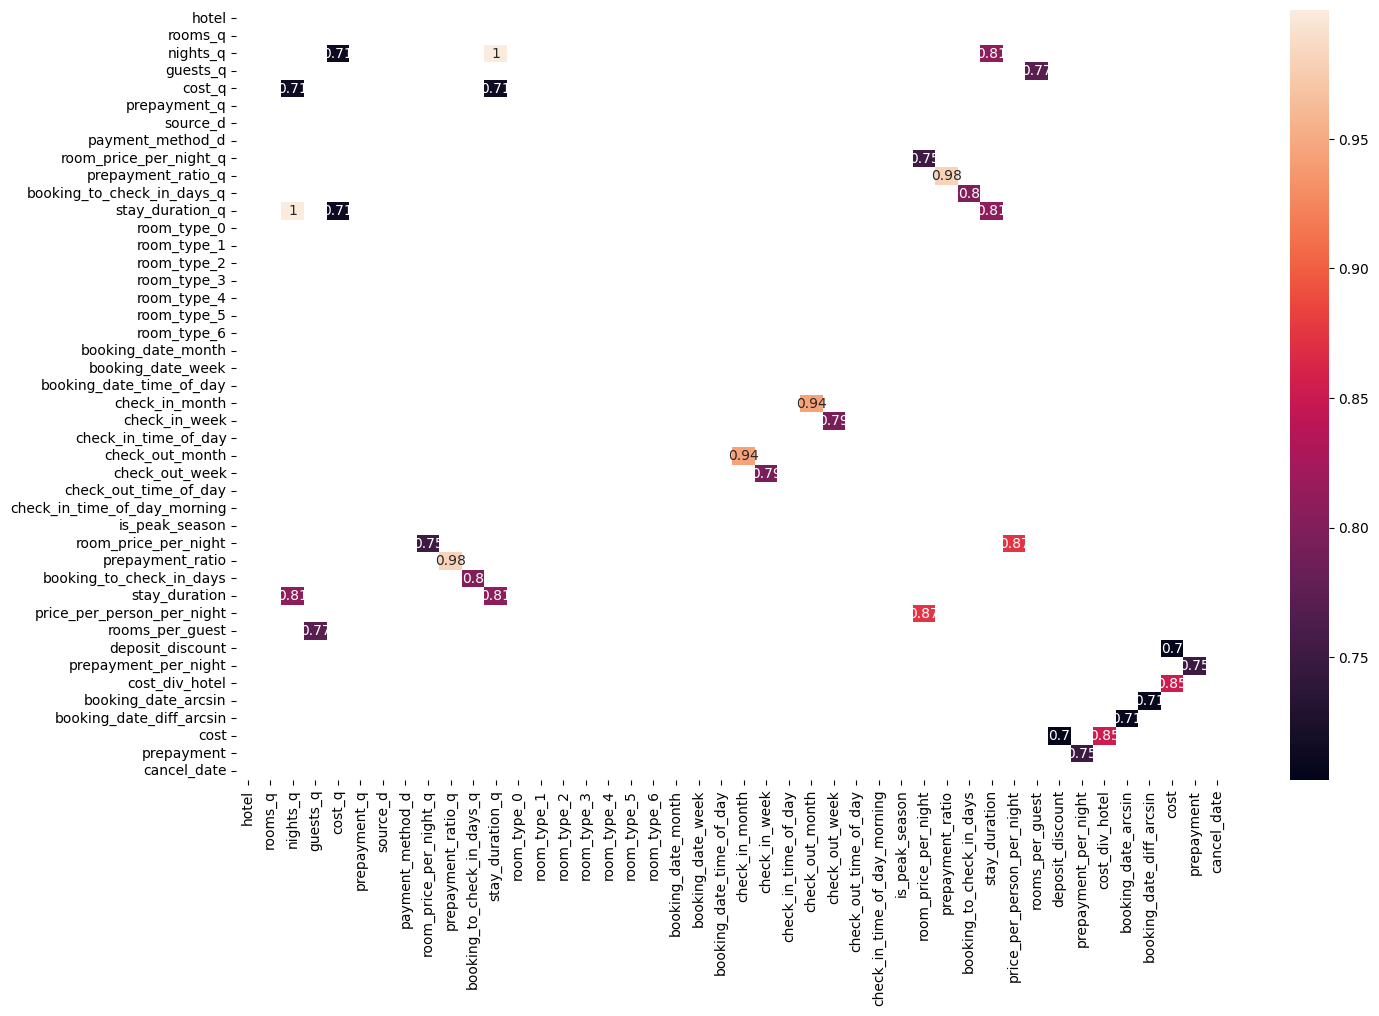

In [ ]:
mat_corr = df_train[new_cat_cols + new_num_cols + num_cols + [target_col]].corr()
filtered_correlations = mat_corr[(mat_corr.abs() > 0.7) & (mat_corr != 1.0)] # оставим только самые большие значения

plt.figure(figsize = (16, 10))
sns.heatmap(filtered_correlations, annot=True)
plt.show()

In [ ]:
(mat_corr[target_col].abs() >= 0.7).value_counts()

,count
cancel_date,
False,43
True,1


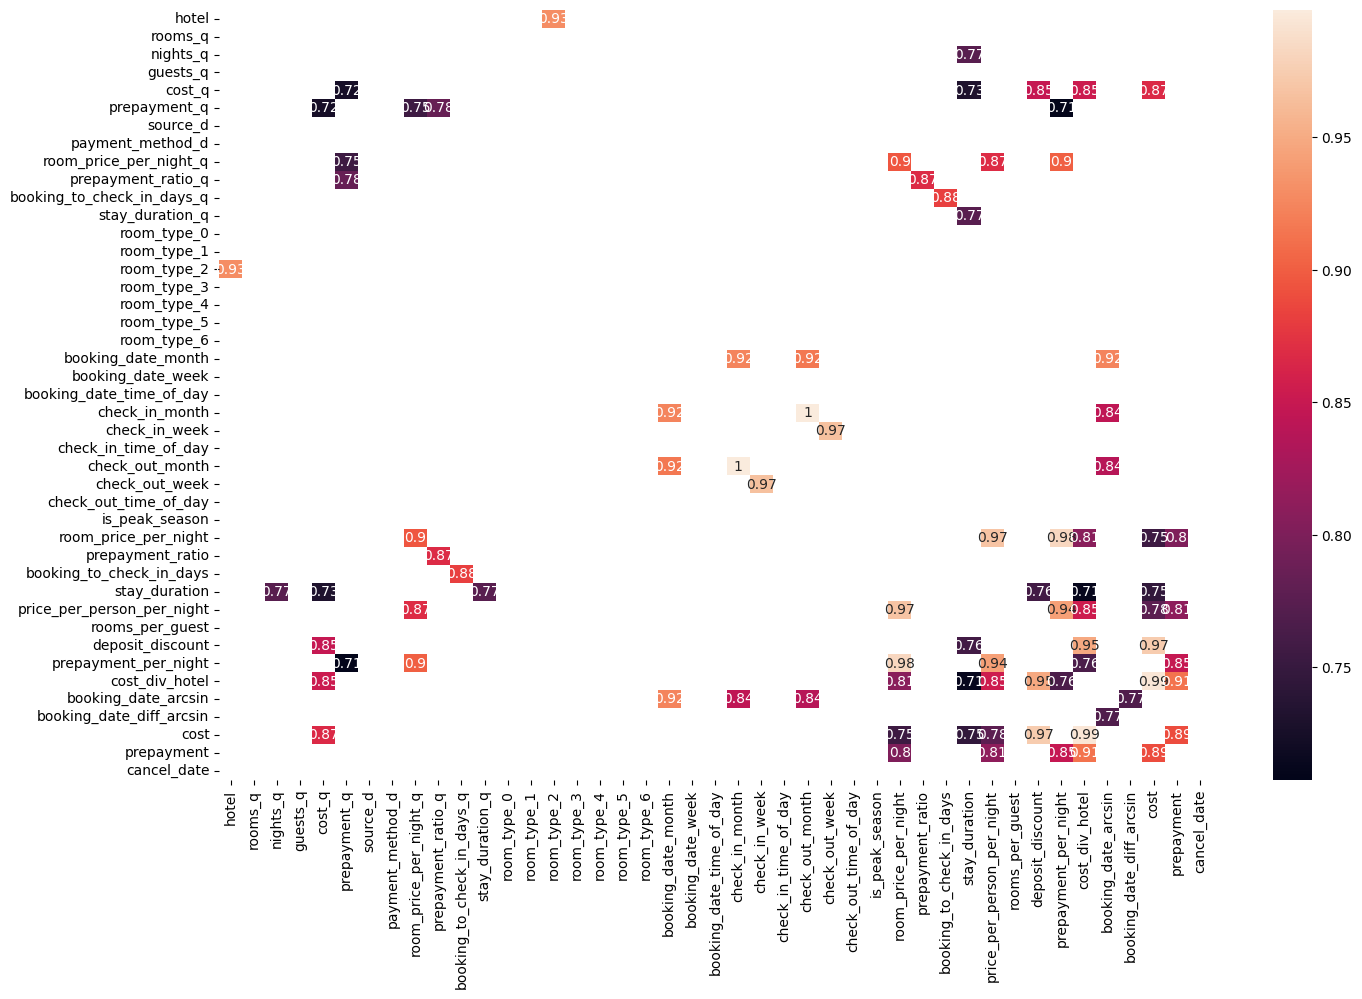

In [ ]:
mat_all_corr = df_train[new_cat_cols + new_num_cols + num_cols + [target_col]].phik_matrix(verbose=False)
filtered_all_correlations = mat_all_corr[(mat_all_corr.abs() > 0.7) & (mat_all_corr != 1.0)] # оставим только самые большие значения

plt.figure(figsize = (16, 10))
sns.heatmap(filtered_all_correlations, annot=True)
plt.show()

In [ ]:
(mat_all_corr[target_col] >= 0.7).value_counts()

,count
cancel_date,
False,42
True,1


# stacking

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train[target_col]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimators = [

    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("CatBoost", cat_model),

    # То, что не дало прироста в ансамбле
    # ("SVM", make_pipeline(preprocessor, LinearSVC(verbose=False))),
    # ("MLP", make_pipeline(preprocessor, MLPClassifier(verbose=False, hidden_layer_sizes=(100, 30, ), alpha=0.001,random_state=75, max_iter = 1300, ))),

]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=2000, random_state=42, verbose=True),
    # final_estimator=RandomForestClassifier(n_estimators = 10_000,
                                           # max_depth = 5,
                                           # verbose=False),
    n_jobs=-1,
    verbose=True,
)

stacking_classifier = meta_model
stacking_classifier

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               iterations=364,
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x780100535b70>)],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42,
                                                      verbose=True),
                   n_jobs=-1, verbose=True)

In [ ]:
stacking_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               iterations=364,
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x780100535b70>)],
                   final_estimator=LogisticRegression(max_iter=2000,
                                                      random_state=42,
                                                      verbose=True),
                   n_jobs=-1, verbose=True)

In [ ]:
pred = stacking_classifier.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
roc_auc_score(y_val, stacking_classifier.predict_proba(X_val)[:, -1])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.8665275178205554

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.037905
1,0.041894
2,0.097489
3,0.131203
4,0.041058
...,...
11213,0.128221
11214,0.146216
11215,0.034612
11216,0.043739


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_7', index=False, header=False)

# stacking 2

In [ ]:
estimators = [

    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("CatBoost", cat_model),

    # То, что не дало прироста в ансамбле
    # ("SVM", make_pipeline(preprocessor, LinearSVC(verbose=False))),
    # ("MLP", make_pipeline(preprocessor, MLPClassifier(verbose=False, hidden_layer_sizes=(100, 30, ), alpha=0.001,random_state=75, max_iter = 1300, ))),

]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 256, 128), alpha=0.001, random_state=SEED, n_iter_no_change=20),
    # final_estimator=RandomForestClassifier(n_estimators = 10_000,
                                           # max_depth = 5,
                                           # verbose=False),
    n_jobs=-1,
    verbose=True,
    passthrough=False
)

stacking_classifier = meta_model
stacking_classifier

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x780100535b70>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 256,
                                                                     128),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
stacking_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x780100535b70>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 256,
                                                                     128),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
pred = stacking_classifier.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
roc_auc_score(y_val, stacking_classifier.predict_proba(X_val)[:, -1])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.8695320035459773

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.022974
1,0.033829
2,0.115901
3,0.130840
4,0.026701
...,...
11213,0.121815
11214,0.151559
11215,0.018229
11216,0.030089


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_9', index=False, header=False)

# parsed data

In [ ]:
h1 = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/hotel1_data.csv')
h2 = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/hotel2_data.csv')
h3 = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/hotel3_data.csv')
h4 = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/hotel4_data.csv')

In [ ]:
# cancel_date = pd.read_excel('/content/drive/MyDrive/HSE_PSB_hack/train.xlsx', usecols=['Дата отмены'])

In [ ]:
# df_train['cancel_date'] = cancel_date

In [ ]:
df_train['cancel_date'] = pd.to_datetime(df_train['cancel_date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_train['check_in'] = pd.to_datetime(df_train['check_in'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_test['check_in'] = pd.to_datetime(df_test['check_in'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
days_until_cancel = (df_train['check_in'] - df_train['cancel_date']).dt.days
df_filtered = df_train.dropna(subset=['cancel_date'])
average_days_until_cancel = int(days_until_cancel.mean())
print("Среднее количество дней отмены брони до въезда:", average_days_until_cancel)

Среднее количество дней отмены брони до въезда: 25


In [ ]:
hotel_dct = {1: h1, 2: h2, 3: h3, 4: h4}
weather_cols = list(h1.columns)[:-1]


def weather_features_by_time_and_hotel(df):
  weather_dct = {}
  check_in_dates = df['check_in'].dt.date
  avg_days_to_cancel = (check_in_dates - pd.Timedelta(days=average_days_until_cancel)).values
  hotels = df['hotel'].values
  #try:
  for i in range(len(df)):
    day_to_cancel, hotel = avg_days_to_cancel[i], hotels[i]
    weather_data = hotel_dct[hotel]
    for col in weather_cols:
      weather_el = weather_data[weather_data['time'] == str(day_to_cancel)][col].values
      if weather_dct.get(col + '_25_days_ago', False) is False:
        if weather_el:
          weather_dct[col + '_25_days_ago'] = [weather_el[0]]
        else:
          weather_dct[col + '_25_days_ago'] = [-666]
      else:
        if weather_el:
          weather_dct[col + '_25_days_ago'].append(weather_el[0])
        else:
          weather_dct[col + '_25_days_ago'].append(-666)
  #except Exception as e:
    #print(e)

  return weather_dct



weather_dct_train = weather_features_by_time_and_hotel(df_train)
weather_dct_test = weather_features_by_time_and_hotel(df_test)

In [ ]:
df_train = pd.concat([df_train, pd.DataFrame(weather_dct_train)], axis = 1)
df_test = pd.concat([df_test, pd.DataFrame(weather_dct_test)], axis = 1)

In [ ]:
# df_train.drop(list(weather_dct_train.keys()), axis = 1, inplace=True), df_test.drop(list(weather_dct_train.keys()), axis = 1, inplace=True)

(None, None)

In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 74 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   reservation_id                         26174 non-null  object        
 1   rooms                                  26174 non-null  int64         
 2   cost                                   26174 non-null  float64       
 3   prepayment                             26174 non-null  int64         
 4   payment_method                         26174 non-null  object        
 5   booking_date                           26174 non-null  object        
 6   target                                 26174 non-null  int64         
 7   check_in                               26174 non-null  datetime64[ns]
 8   nights                                 26174 non-null  int64         
 9   check_out                              26174 non-null  object

(None, None)

In [ ]:
for col in new_num_cols:
  if True in df_train[col].isna().values:
    df_train[col].fillna(-666, inplace=True)

for col in new_num_cols:
  if True in df_test[col].isna().values:
    df_test[col].fillna(-666, inplace=True)

In [ ]:
for i in ['tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres']:
  print(i + '_25_days_ago,')

tavg_25_days_ago,
tmin_25_days_ago,
tmax_25_days_ago,
prcp_25_days_ago,
wdir_25_days_ago,
wspd_25_days_ago,
pres_25_days_ago,


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26174 entries, 0 to 26173
Data columns (total 74 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   reservation_id                         26174 non-null  object        
 1   rooms                                  26174 non-null  int64         
 2   cost                                   26174 non-null  float64       
 3   prepayment                             26174 non-null  int64         
 4   payment_method                         26174 non-null  object        
 5   booking_date                           26174 non-null  object        
 6   target                                 26174 non-null  int64         
 7   check_in                               26174 non-null  datetime64[ns]
 8   nights                                 26174 non-null  int64         
 9   check_out                              26174 non-null  object

In [ ]:
hotel_ratings = {
    1: {'stars': 4,
        'rating': np.mean([10, 8.3, 9, 10, 9.1, 9, 4.5 / 5 * 10, 4.7 / 5 * 10]),
        'num_feedbacks': 796 + 10 + 6 + 2 + 384 + 6 + 167 + 9,
        'total_num_rooms': 100
    },
    2: {
        'stars': 3,
        'rating': np.mean([10, 9.6, 9.4, 9.6, 4.5 / 5 * 10, 10]),
        'num_feedbacks': 843 + 17 + 4 + 12 + 27 + 21,
        'total_num_rooms': 50
    },
    3: {
        'stars': 3,
        'rating': np.mean([10, 2, 9, 9.4, 9, 4.7, 5]),
        'num_feedbacks': 2096 + 2 + 19 + 345 + 16 + 198 + 12,
        'total_num_rooms': 61
    },
    4: {
        'stars': 3,
        'rating': np.mean([10, 9.5, 9.6, 9.5, 10, 10]),
        'num_feedbacks': 359 + 2 + 14 + 1 + 1 + 3,
        'total_num_rooms': 15
    }
}

In [ ]:
def create_hotel_reting_features(df):
  for col in ['stars', 'rating', 'num_feedbacks', 'total_num_rooms']:
    values = [hotel_ratings[hotel][col] for hotel in range(1, 5)]
    df[col] = df['hotel'].map({hotel: value for hotel, value in zip(range(1, 5), values)})

  return df

df_train = create_hotel_reting_features(df_train)
df_test = create_hotel_reting_features(df_test)

In [ ]:
hotels = {
    1: {
        'Номер «Стандарт»': {
            'max_people': 2,
            'area': 19,
            'num_rooms': 1,
            #'bed': 'single or double',
            # 'double_bed': True,
            # 'two_single_bed': True,
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': False,
            'price_today': 8600
        },
        'Номер «Люкс»': {
            'max_people': 3,
            'area': 35,
            'num_rooms': 2,
            #'bed': 'double',
            # 'double_bed': True,
            # 'two_single_bed': False,
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': False,
            'price_today': 13500
        },
        'Коттедж с 2 спальнями': {
            'max_people': 6,
            'area': 125,
            'num_rooms': 2,
            #'bed': '2 single, double, sofa',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 26300
        },
        'Коттедж с 3 спальнями': {
            'max_people': 8,
            'area': 180,
            'num_rooms': 3,
            #'bed': '2 double, 2 single, sofa',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 31700
        },
        'Номер «Стандарт» для маломобильных групп населения': {
            'max_people': 2,
            'area': 19,
            'num_rooms': 1,
            #'bed': 'single or double',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': False,
            'price_today': 14100 # хз конкретно, там было непонятно
        },
        'Апартаменты с 2 спальнями с отдельным входом': {
            'max_people': 5,
            'area': 60,
            'num_rooms': 2,
            #'bed': '2 single or double',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 14100
        },
    },

    2: {
        'Номер «Стандарт»': {
            'max_people': 2,
            'area': 19,
            'num_rooms': 1,
            #'bed': '2 single or double',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 11600
        },
        'Номер «Студия»': {
            'max_people': 4,
            'area': 39,
            'num_rooms': 1,
            #'bed': '2 single or double',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 18100
        },
    },

    3: {
        'Номер «Стандарт»': {
            'max_people': 3,
            'area': 20,
            'num_rooms': 1,
            #'bed': '2 single',
            'with_pet': False,
            'wi_fi': False,
            'private_entrance': True,
            'price_today': 15200
        },
    },

    4: {
        'Номер «Студия»': {
            'max_people': 4,
            'area': 38,
            'num_rooms': 1,
            #'bed': '2 single or king',
            'with_pet': False,
            'wi_fi': True,
            'private_entrance': True,
            'price_today': 24000
        },
    }
}

# preprocessed data saving 4

In [ ]:
df_train.to_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_4', encoding='utf-8', index=False, header=True)
df_test.to_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_4', encoding='utf-8', index=False, header=True)

# preprocessed data importing 4

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_4')
df_test = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_4')

# stacking 3

In [ ]:
len(df_train.columns), len(df_test.columns)

(67, 64)

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train["target"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimators = [

    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("CatBoost", cat_model),

    # То, что не дало прироста в ансамбле
    # ("SVM", make_pipeline(preprocessor, LinearSVC(verbose=False))),
    # ("MLP", make_pipeline(preprocessor, MLPClassifier(verbose=False, hidden_layer_sizes=(100, 30, ), alpha=0.001,random_state=75, max_iter = 1300, ))),

]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 256, 128), alpha=0.001, random_state=SEED, n_iter_no_change=20),
    # final_estimator=RandomForestClassifier(n_estimators = 10_000,
                                           # max_depth = 5,
                                           # verbose=False),
    n_jobs=-1,
    verbose=True,
    passthrough=False
)

stacking_classifier = meta_model
stacking_classifier

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7b314db9e9b0>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 256,
                                                                     128),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
stacking_classifier.fit(X_train, y_train)

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7b314db9e9b0>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 256,
                                                                     128),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
pred = stacking_classifier.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
roc_auc_score(y_val, stacking_classifier.predict_proba(X_val)[:, -1])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


0.8677603922060119

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.021060
1,0.036058
2,0.125281
3,0.144461
4,0.020265
...,...
11213,0.112764
11214,0.119067
11215,0.020623
11216,0.031739


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_10', index=False, header=False)

# feature importance

In [ ]:
xgb_model_check = XGBClassifier(**xgb_best_params).fit(X_train, y_train)

In [ ]:
'prepayment', 'payment_method_d', 'source_d',
'cost', 'все погодные', 'booking_date_diff_arcsin', 'все типы номеров', 'rooms_q', 'nights_q'

In [ ]:
sorted(list(zip(X.columns, xgb_model_check.feature_importances_)), key=lambda x: x[-1], reverse=True)

[('prepayment_ratio_q', 0.38052875),
 ('prepayment', 0.19228178),
 ('prepayment_ratio', 0.16907904),
 ('payment_method_d', 0.084425524),
 ('prepayment_per_night', 0.06581076),
 ('booking_to_check_in_days', 0.031549443),
 ('source_d', 0.027935462),
 ('booking_to_check_in_days_q', 0.026224704),
 ('deposit_discount', 0.0054708277),
 ('booking_date_arcsin', 0.004883945),
 ('price_per_person_per_night', 0.004114611),
 ('cost_div_hotel', 0.0027793602),
 ('pres_25_days_ago', 0.0025800376),
 ('check_out_month', 0.0023357456),
 ('hotel', 0.0),
 ('rooms_q', 0.0),
 ('nights_q', 0.0),
 ('guests_q', 0.0),
 ('cost_q', 0.0),
 ('prepayment_q', 0.0),
 ('room_price_per_night_q', 0.0),
 ('stay_duration_q', 0.0),
 ('room_type_0', 0.0),
 ('room_type_1', 0.0),
 ('room_type_2', 0.0),
 ('room_type_3', 0.0),
 ('room_type_4', 0.0),
 ('room_type_5', 0.0),
 ('room_type_6', 0.0),
 ('booking_date_month', 0.0),
 ('booking_date_week', 0.0),
 ('booking_date_time_of_day', 0.0),
 ('check_in_month', 0.0),
 ('check_in_wee

In [ ]:
lgbm_model_check = LGBMClassifier(**lgbm_best_params).fit(X_train, y_train)

In [ ]:
'booking_to_check_in_days', 'payment_method_d', 'source_d',

In [ ]:
sorted(list(zip(X.columns, lgbm_model_check.feature_importances_)), key=lambda x: x[-1], reverse=True)

[('booking_to_check_in_days', 277),
 ('payment_method_d', 143),
 ('booking_date_arcsin', 100),
 ('source_d', 92),
 ('booking_to_check_in_days_q', 92),
 ('prepayment_per_night', 76),
 ('prepayment_ratio', 51),
 ('price_per_person_per_night', 49),
 ('prepayment', 44),
 ('pres_25_days_ago', 41),
 ('cost', 40),
 ('check_out_month', 39),
 ('cost_div_hotel', 39),
 ('deposit_discount', 32),
 ('wdir_25_days_ago', 25),
 ('room_price_per_night', 23),
 ('stay_duration', 23),
 ('tmin_25_days_ago', 23),
 ('wspd_25_days_ago', 21),
 ('check_in_month', 19),
 ('tmax_25_days_ago', 19),
 ('booking_date_diff_arcsin', 15),
 ('hotel', 12),
 ('booking_date_month', 12),
 ('prcp_25_days_ago', 12),
 ('check_in_week', 11),
 ('tavg_25_days_ago', 10),
 ('room_type_6', 8),
 ('booking_date_time_of_day', 8),
 ('guests_q', 7),
 ('booking_date_week', 7),
 ('prepayment_ratio_q', 4),
 ('check_out_week', 3),
 ('cost_q', 2),
 ('room_type_2', 2),
 ('is_peak_season', 2),
 ('nights_q', 1),
 ('room_price_per_night_q', 1),
 ('r

In [ ]:
cb_model_check = CatBoostClassifier(**cb_best_params).fit(X_train, y_train)

In [ ]:
'prepayment', 'prepayment_ratio'
to_delete = 'check_in_time_of_day_morning', 'rooms_q', 'room_types'

In [ ]:
sorted(list(zip(X.columns, cb_model_check.feature_importances_)), key=lambda x: x[-1], reverse=True)

[('payment_method_d', 11.610667273133428),
 ('booking_to_check_in_days', 8.012796559047793),
 ('prepayment', 7.477595561916173),
 ('prepayment_per_night', 6.544397096767999),
 ('prepayment_ratio', 6.150520160448114),
 ('booking_to_check_in_days_q', 4.254711378473424),
 ('prepayment_ratio_q', 4.2350858698688185),
 ('booking_date_arcsin', 3.9564386307841626),
 ('booking_date_diff_arcsin', 3.808585829651819),
 ('wdir_25_days_ago', 3.0871665603620255),
 ('price_per_person_per_night', 2.917935370466892),
 ('pres_25_days_ago', 2.884535271999668),
 ('wspd_25_days_ago', 2.8276677367019483),
 ('cost_div_hotel', 2.2759354193053603),
 ('cost', 2.0032767922696983),
 ('tmax_25_days_ago', 1.9751755350156408),
 ('room_price_per_night', 1.9242033534617575),
 ('tmin_25_days_ago', 1.729677709012681),
 ('tavg_25_days_ago', 1.7094461384943127),
 ('check_out_month', 1.7070229012738012),
 ('source_d', 1.5858010515684158),
 ('prcp_25_days_ago', 1.5453691692764926),
 ('prepayment_q', 1.4807573503225904),
 ('b

# lucky predict experiments

In [ ]:
lucky_predict = pd.read_csv(SAVE_PATH + 'predict_9')

In [ ]:
def classify_probabilities(probabilities, threshold=0.5):
    labels = np.where(probabilities >= threshold, 1, 0)
    return labels

In [ ]:
for tr in [0.2, 0.4, 0.5, 0.6, 0.8]:
  print(tr, f1_score(y_val, classify_probabilities(stacking_classifier.predict_proba(X_val)[:, -1], threshold=tr)))

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.2 0.6659804426145136
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Curren

In [ ]:
submit_pred = pd.Series(classify_probabilities(stacking_classifier.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])[:, -1], threshold=0.6))
submit_pred.value_counts()

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


,count
0,10174
1,1044


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_12', index=False, header=False)

# voting classifier 3

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train[target_col]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimator = VotingClassifier([
    ('lgbm', lgbm_model), ('cb', cat_model), ('xgb', xgb_model),
], voting='soft', n_jobs=-1)

In [ ]:
estimator.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.6314632033193033,
                                             bagging_freq=7,
                                             colsample_bynode=0.7216731059131875,
                                             colsample_bytree=0.8656114831191837,
                                             is_unbalance=True, iterations=364,
                                             lambda_l1=0.010704832348942385,
                                             lambda_l2=0.0010550603312438993,
                                             learning_rate=0.01844097043806042,
                                             max_depth=4, min_data_in_leaf=71,
                                             num_leaves=22...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            iterations=814,
                                            lambda=5.299997901477308,
                                            learning_rate=0.04396292285758932,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, ...))],
                 n_jobs=-1, voting='soft')

In [ ]:
pred = estimator.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.094864
1,0.121587
2,0.235510
3,0.332581
4,0.086896
...,...
11213,0.283242
11214,0.247466
11215,0.070406
11216,0.104053


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_13', index=False, header=False)

# stacking 4

In [ ]:
X = df_train[new_cat_cols + new_num_cols + num_cols]
y = df_train["target"]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=SEED, stratify=y)

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
estimators = [

    ("XGBoost", xgb_model),
    ("LightGBM", lgbm_model),
    ("CatBoost", cat_model),

    # То, что не дало прироста в ансамбле
    # ("SVM", make_pipeline(preprocessor, LinearSVC(verbose=False))),
    # ("MLP", make_pipeline(preprocessor, MLPClassifier(verbose=False, hidden_layer_sizes=(100, 30, ), alpha=0.001,random_state=75, max_iter = 1300, ))),

]

# в качестве мета-модели будем использовать LogisticRegression
meta_model = StackingClassifier(
    estimators=estimators,
    final_estimator=MLPClassifier(hidden_layer_sizes=(128, 32), alpha=0.001, random_state=SEED, n_iter_no_change=20),
    # final_estimator=RandomForestClassifier(n_estimators = 10_000,
                                           # max_depth = 5,
                                           # verbose=False),
    n_jobs=-1,
    verbose=True,
    passthrough=False
)

stacking_classifier = meta_model
stacking_classifier

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7b31500f03a0>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(128, 64),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
stacking_classifier.fit(X, y)

StackingClassifier(estimators=[('XGBoost',
                                XGBClassifier(alpha=0.004501306460529177,
                                              base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=0.7382293731620369,
                                              colsample_bytree=0.955629520902894,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              i...
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary')),
                               ('CatBoost',
                                <catboost.core.CatBoostClassifier object at 0x7b31500f03a0>)],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(128, 64),
                                                 n_iter_no_change=20,
                                                 random_state=42),
                   n_jobs=-1, verbose=True)

In [ ]:
pred = stacking_classifier.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.031693
1,0.046503
2,0.110664
3,0.186377
4,0.027816
...,...
11213,0.130988
11214,0.116667
11215,0.023183
11216,0.034053


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_14', index=False, header=False)

#

# stacking 5

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
stacking_1_base_models = [
    ('logreg', LogisticRegression()),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn5', KNeighborsClassifier(n_neighbors=5)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('knn9', KNeighborsClassifier(n_neighbors=9)),
    ('tree3', DecisionTreeClassifier(max_depth=3)),
    ('tree5', DecisionTreeClassifier(max_depth=5)),
    ('tree7', DecisionTreeClassifier(max_depth=7)),
]

stacking_2_base_models = [
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier()),
    ('et', ExtraTreesClassifier())
]

stacking_3_base_models = [
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis())
]

stacking_4_base_models = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', cat_model)
]

# Создание стэкингов
stacking_1 = StackingClassifier(
    estimators=stacking_1_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_2 = StackingClassifier(
    estimators=stacking_2_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_3 = StackingClassifier(
    estimators=stacking_3_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_4 = StackingClassifier(
    estimators=stacking_4_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

# Объединение стэкингов в финальную модель
# Для этого нам нужно сначала обучить каждый стэкинг по отдельности
# stacking_1.fit(X, y)
# stacking_2.fit(X, y)
# stacking_3.fit(X, y)
# stacking_4.fit(X, y)

# # Получение мета-признаков
# meta_features_1 = stacking_1.predict(X)
# meta_features_2 = stacking_2.predict(X)
# meta_features_3 = stacking_3.predict(X)
# meta_features_4 = stacking_4.predict(X)

# # Создание финальной модели
# final_meta_features = np.column_stack((meta_features_1, meta_features_2, meta_features_3, meta_features_4))
# final_model = MLPClassifier()

stacking_final = StackingClassifier(
    estimators=[
        ('st1', stacking_1),
        ('st2', stacking_2),
        ('st3', stacking_3),
        ('st4', stacking_4)
    ],
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=5
)

# Обучение финальной метамодели


In [ ]:
stacking_final

StackingClassifier(cv=5,
                   estimators=[('st1',
                                StackingClassifier(cv=3,
                                                   estimators=[('logreg',
                                                                LogisticRegression()),
                                                               ('knn3',
                                                                KNeighborsClassifier(n_neighbors=3)),
                                                               ('knn5',
                                                                KNeighborsClassifier()),
                                                               ('knn7',
                                                                KNeighborsClassifier(n_neighbors=7)),
                                                               ('knn9',
                                                                KNeighborsClassifier(n_neighbors=9)),
                                                               ('tree3',
                                                                DecisionTreeClassifier(max_depth=3)),
                                                               ('tree5',
                                                                DecisionTreeClass...
                                                                               lambda_l2=0.0010550603312438993,
                                                                               learning_rate=0.01844097043806042,
                                                                               max_depth=4,
                                                                               min_data_in_leaf=71,
                                                                               num_leaves=221,
                                                                               objective='binary')),
                                                               ('catboost',
                                                                <catboost.core.CatBoostClassifier object at 0x7b31500f03a0>)],
                                                   final_estimator=LogisticRegression()))],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 128,
                                                                     64),
                                                 n_iter_no_change=30,
                                                 random_state=42))

In [ ]:
stacking_final.fit(X, y)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

StackingClassifier(cv=5,
                   estimators=[('st1',
                                StackingClassifier(cv=3,
                                                   estimators=[('logreg',
                                                                LogisticRegression()),
                                                               ('knn3',
                                                                KNeighborsClassifier(n_neighbors=3)),
                                                               ('knn5',
                                                                KNeighborsClassifier()),
                                                               ('knn7',
                                                                KNeighborsClassifier(n_neighbors=7)),
                                                               ('knn9',
                                                                KNeighborsClassifier(n_neighbors=9)),
                                                               ('tree3',
                                                                DecisionTreeClassifier(max_depth=3)),
                                                               ('tree5',
                                                                DecisionTreeClass...
                                                                               lambda_l2=0.0010550603312438993,
                                                                               learning_rate=0.01844097043806042,
                                                                               max_depth=4,
                                                                               min_data_in_leaf=71,
                                                                               num_leaves=221,
                                                                               objective='binary')),
                                                               ('catboost',
                                                                <catboost.core.CatBoostClassifier object at 0x7b31500f03a0>)],
                                                   final_estimator=LogisticRegression()))],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 128,
                                                                     64),
                                                 n_iter_no_change=30,
                                                 random_state=42))

In [ ]:
pred = stacking_final.predict_proba(df_test[new_cat_cols + new_num_cols + num_cols])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.022370
1,0.033761
2,0.057109
3,0.128639
4,0.027403
...,...
11213,0.113255
11214,0.127733
11215,0.019508
11216,0.025536


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_15', index=False, header=False)

# plans 3
1. добавить больше фичей с использованием погоды
2. сделать новые фичи из внешних данных

In [ ]:
min(df_train.check_in.min(), df_test.check_in.min()),max(df_train.check_in.max(), df_test.check_in.max()),

('2022-01-01 15:00:00', '2024-09-01 15:00:00')

# parsed data 2

In [ ]:
'source_stay_duration',
'prepayment_bookings',
'payment_method_avg_price',
'prepayment_normalized_stay',
'source_cost_ratio',
'combined_indicators',
'cancel_hotel_room_type'

'cancel_hotel_room_type'

In [ ]:
def create_new_features_using_only_useful(df):
  df['source_stay_duration'] = df['source_d'] * df['stay_duration']
  df['prepayment_bookings'] = df['prepayment'] * df['rooms_per_guest']
  df['payment_method_avg_price'] = df['payment_method_d'] * df['price_per_person_per_night']
  df['prepayment_normalized_stay'] = (df['stay_duration'] - df['stay_duration'].mean()) / df['stay_duration'].std() * df['prepayment']
  df['prepayment_normalized_stay'].fillna(-666, inplace=True)
  df['source_cost_ratio'] = df['cost_div_hotel'] / df['source_d']
  df['source_cost_ratio'].fillna(-666, inplace=True)
  df['source_cost_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
  df['combined_indicators'] = df['prepayment'] * df['payment_method_d'] * df['source_d']
  df['booking_to_checkin_source_interaction'] = df['source_d'] * df['booking_to_check_in_days']
  return df


In [ ]:
df_train = create_new_features_using_only_useful(df_train)
df_test = create_new_features_using_only_useful(df_test)

In [ ]:
cancels_for_hotel_room_type = {(1, 'Номер «Стандарт»'): 871,
 (3, 'Номер «Стандарт»'): 1582,
 (2, 'Номер «Стандарт»'): 865,
 (2, 'Номер «Студия»'): 534,
 (4, 'Номер «Студия»'): 526,
 (1, 'Апартаменты с 2 спальнями с отдельным входом'): 424,
 (1, 'Номер «Люкс»'): 184,
 (1, 'Коттедж с 3 спальнями'): 132,
 (1, 'Коттедж с 2 спальнями'): 135,
 (1, 'Номер «Стандарт» для маломобильных групп населения'): 5}


def remove_room_type_indexing(string_list):
    result = []
    for string in string_list:
        result.append(' '.join(string.split()[1:]).strip())

    return result

def apply_cancels_for_hotel_room_type(x):
    room_type = x.room_type if '\n' not in x.room_type else remove_room_type_indexing(x.room_type.split('\n'))[0]
    if (x.hotel, room_type) not in cancels_for_hotel_room_type:
        return 0

    return cancels_for_hotel_room_type[(x.hotel, room_type)]

In [ ]:
df_train['cancel_hotel_room_type'] = df_train.apply(apply_cancels_for_hotel_room_type,
                                                    axis=1)
df_test['cancel_hotel_room_type'] = df_test.apply(apply_cancels_for_hotel_room_type,
                                                    axis=1)

# preprocessed data saving 5

In [ ]:
df_train.to_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_5', encoding='utf-8', index=False, header=True)
df_test.to_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_5', encoding='utf-8', index=False, header=True)

# preprocessed data importing 5

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/train_p_5')
df_test = pd.read_csv('/content/drive/MyDrive/HSE_PSB_hack/test_p_5')

# stacking 6

In [ ]:
not_to_use = ['check_in_time_of_day_morning', 'rooms_q'] + [f'room_type_{i}' for i in range(7)]
without_not_to_use_cat_cols = list(set(new_cat_cols) - set(not_to_use))

In [ ]:
columns_set = list(set(new_cat_cols + new_num_cols + num_cols) - set(not_to_use))
len(columns_set), len(new_cat_cols + new_num_cols + num_cols)

(48, 57)

In [ ]:
X = df_train[columns_set]
y = df_train["target"]

In [ ]:
cb_best_params_2 = { 'loss_function': 'Logloss',
                   'verbose': False,
                   'random_state': SEED,
                   'cat_features': without_not_to_use_cat_cols,
                   'auto_class_weights': 'Balanced'
                  }

In [ ]:
cat_model = CatBoostClassifier(**cb_best_params_2)
xgb_model = XGBClassifier(**xgb_best_params)
lgbm_model = LGBMClassifier(**lgbm_best_params)

In [ ]:
stacking_1_base_models = [
    ('logreg', LogisticRegression()),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn5', KNeighborsClassifier(n_neighbors=5)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('knn9', KNeighborsClassifier(n_neighbors=9)),
    ('knn12', KNeighborsClassifier(n_neighbors=12)),
    ('knn15', KNeighborsClassifier(n_neighbors=15)),
    ('tree3', DecisionTreeClassifier(max_depth=3)),
    ('tree5', DecisionTreeClassifier(max_depth=5)),
    ('tree7', DecisionTreeClassifier(max_depth=7)),

]

stacking_2_base_models = [
    ('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier()),
    ('et', ExtraTreesClassifier())
]

stacking_3_base_models = [
    ('lda', LinearDiscriminantAnalysis()),
    ('qda', QuadraticDiscriminantAnalysis())
]

stacking_4_base_models = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', cat_model)
]

# Создание стэкингов
stacking_1 = StackingClassifier(
    estimators=stacking_1_base_models,
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=4
)

stacking_2 = StackingClassifier(
    estimators=stacking_2_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_3 = StackingClassifier(
    estimators=stacking_3_base_models,
    final_estimator=LogisticRegression(),
    cv=3
)

stacking_4 = StackingClassifier(
    estimators=stacking_4_base_models,
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=4
)

# Объединение стэкингов в финальную модель
# Для этого нам нужно сначала обучить каждый стэкинг по отдельности
# stacking_1.fit(X, y)
# stacking_2.fit(X, y)
# stacking_3.fit(X, y)
# stacking_4.fit(X, y)

# # Получение мета-признаков
# meta_features_1 = stacking_1.predict(X)
# meta_features_2 = stacking_2.predict(X)
# meta_features_3 = stacking_3.predict(X)
# meta_features_4 = stacking_4.predict(X)

# # Создание финальной модели
# final_meta_features = np.column_stack((meta_features_1, meta_features_2, meta_features_3, meta_features_4))
# final_model = MLPClassifier()

stacking_final = StackingClassifier(
    estimators=[
        ('st1', stacking_1),
        ('st2', stacking_2),
        ('st3', stacking_3),
        ('st4', stacking_4),
        # ('svm', SVC())
    ],
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=5
)

# Обучение финальной метамодели


In [ ]:
stacking_final

StackingClassifier(cv=5,
                   estimators=[('st1',
                                StackingClassifier(cv=4,
                                                   estimators=[('logreg',
                                                                LogisticRegression()),
                                                               ('knn3',
                                                                KNeighborsClassifier(n_neighbors=3)),
                                                               ('knn5',
                                                                KNeighborsClassifier()),
                                                               ('knn7',
                                                                KNeighborsClassifier(n_neighbors=7)),
                                                               ('knn9',
                                                                KNeighborsClassifier(n_neighbors=9)),
                                                               ('knn12',
                                                                KNeighborsClassifier(n_neighbors=12)),
                                                               ('knn15',
                                                                KNeighborsClassi...
                                                                               min_data_in_leaf=71,
                                                                               num_leaves=221,
                                                                               objective='binary')),
                                                               ('catboost',
                                                                <catboost.core.CatBoostClassifier object at 0x7b69b9129f60>)],
                                                   final_estimator=MLPClassifier(alpha=0.001,
                                                                                 hidden_layer_sizes=(256,
                                                                                                     128,
                                                                                                     64),
                                                                                 n_iter_no_change=30,
                                                                                 random_state=42)))],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 128,
                                                                     64),
                                                 n_iter_no_change=30,
                                                 random_state=42))

In [ ]:
with parallel_backend('loky'):
  stacking_final.fit(X, y)

In [ ]:
pred = stacking_final.predict_proba(df_test[columns_set])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.022660
1,0.025466
2,0.113394
3,0.113537
4,0.021666
...,...
11213,0.122972
11214,0.150728
11215,0.018650
11216,0.022630


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_15', index=False, header=False)

In [ ]:
for col in columns_set:
  if np.isinf(df_train[col]).any():
    print(col)

In [ ]:
def check_for_issues(df):
      for column in df.columns:
          if np.isinf(df[column]).any():
              print(f"Столбец '{column}' содержит значения inf.")
          if (df[column] > np.finfo(np.float64).max).any():
              print(f"Столбец '{column}' содержит значения, превышающие max для float64.")
          if (df[column] < np.finfo(np.float64).min).any():
              print(f"Столбец '{column}' содержит значения, меньше min для float64.")

check_for_issues(df_train[columns_set])

# voting classifier 4

In [ ]:
estimator = VotingClassifier([
    ('lgbm', lgbm_model), ('cb', cat_model), ('xgb', xgb_model),
], voting='soft', n_jobs=-1)

In [ ]:
estimator.fit(X, y)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(bagging_fraction=0.6314632033193033,
                                             bagging_freq=7,
                                             colsample_bynode=0.7216731059131875,
                                             colsample_bytree=0.8656114831191837,
                                             is_unbalance=True, iterations=364,
                                             lambda_l1=0.010704832348942385,
                                             lambda_l2=0.0010550603312438993,
                                             learning_rate=0.01844097043806042,
                                             max_depth=4, min_data_in_leaf=71,
                                             num_leaves=22...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            iterations=814,
                                            lambda=5.299997901477308,
                                            learning_rate=0.04396292285758932,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, ...))],
                 n_jobs=-1, voting='soft')

In [ ]:
pred = estimator.predict_proba(df_test[columns_set])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.092583
1,0.106188
2,0.233882
3,0.315018
4,0.080736
...,...
11213,0.264428
11214,0.322759
11215,0.063553
11216,0.096415


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_17', index=False, header=False)

# stacking 7

In [ ]:
stacking_1_base_models = [
    ('logreg', LogisticRegression()),
    ('knn3', KNeighborsClassifier(n_neighbors=3)),
    ('knn5', KNeighborsClassifier(n_neighbors=5)),
    ('knn7', KNeighborsClassifier(n_neighbors=7)),
    ('knn9', KNeighborsClassifier(n_neighbors=9)),
    ('knn12', KNeighborsClassifier(n_neighbors=12)),
    ('knn15', KNeighborsClassifier(n_neighbors=15)),
    ('tree3', DecisionTreeClassifier(max_depth=3)),
    ('tree5', DecisionTreeClassifier(max_depth=5)),
    ('tree7', DecisionTreeClassifier(max_depth=7)),

]

stacking_2_base_models = [
    #('rf', RandomForestClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier()),
    # ('et', ExtraTreesClassifier())
]

# stacking_3_base_models = [
#     ('lda', LinearDiscriminantAnalysis()),
#     ('qda', QuadraticDiscriminantAnalysis())
# ]

stacking_4_base_models = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('catboost', cat_model)
]

# Создание стэкингов
stacking_1 = StackingClassifier(
    estimators=stacking_1_base_models,
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=2
)

stacking_2 = StackingClassifier(
    estimators=stacking_2_base_models,
    final_estimator=LogisticRegression(),
    cv=2
)

stacking_3 = StackingClassifier(
    estimators=stacking_3_base_models,
    final_estimator=LogisticRegression(),
    cv=2
)

stacking_4 = StackingClassifier(
    estimators=stacking_4_base_models,
    final_estimator=LogisticRegression(),
    cv=2
)

# Объединение стэкингов в финальную модель
# Для этого нам нужно сначала обучить каждый стэкинг по отдельности
# stacking_1.fit(X, y)
# stacking_2.fit(X, y)
# stacking_3.fit(X, y)
# stacking_4.fit(X, y)

# # Получение мета-признаков
# meta_features_1 = stacking_1.predict(X)
# meta_features_2 = stacking_2.predict(X)
# meta_features_3 = stacking_3.predict(X)
# meta_features_4 = stacking_4.predict(X)

# # Создание финальной модели
# final_meta_features = np.column_stack((meta_features_1, meta_features_2, meta_features_3, meta_features_4))
# final_model = MLPClassifier()

stacking_final = StackingClassifier(
    estimators=[
        ('st1', stacking_1),
        #('st2', stacking_2),
        #('st3', stacking_3),
        ('st4', stacking_4),
        # ('svm', SVC()),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=MLPClassifier(hidden_layer_sizes=(256, 128, 64), alpha=0.001, random_state=SEED, n_iter_no_change=30),
    cv=2
)

# Обучение финальной метамодели
stacking_final

StackingClassifier(cv=2,
                   estimators=[('st1',
                                StackingClassifier(cv=2,
                                                   estimators=[('logreg',
                                                                LogisticRegression()),
                                                               ('knn3',
                                                                KNeighborsClassifier(n_neighbors=3)),
                                                               ('knn5',
                                                                KNeighborsClassifier()),
                                                               ('knn7',
                                                                KNeighborsClassifier(n_neighbors=7)),
                                                               ('knn9',
                                                                KNeighborsClassifier(n_neighbors=9)),
                                                               ('knn12',
                                                                KNeighborsClassifier(n_neighbors=12)),
                                                               ('knn15',
                                                                KNeighborsClassi...
                                               colsample_bynode=0.7216731059131875,
                                               colsample_bytree=0.8656114831191837,
                                               is_unbalance=True,
                                               iterations=364,
                                               lambda_l1=0.010704832348942385,
                                               lambda_l2=0.0010550603312438993,
                                               learning_rate=0.01844097043806042,
                                               max_depth=4, min_data_in_leaf=71,
                                               num_leaves=221,
                                               objective='binary'))],
                   final_estimator=MLPClassifier(alpha=0.001,
                                                 hidden_layer_sizes=(256, 128,
                                                                     64),
                                                 n_iter_no_change=30,
                                                 random_state=42))

In [ ]:
with parallel_backend('loky'):
  stacking_final.fit(X, y)

In [ ]:
pred = stacking_final.predict_proba(df_test[columns_set])

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010550603312438993
[LightGBM] [Warning] lambda_l1 is set=0.010704832348942385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010704832348942385
[LightGBM] [Warning] bagging_fraction is set=0.6314632033193033, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6314632033193033
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.0010550603312438993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

In [ ]:
submit_pred = pd.Series(pred[:, -1])
submit_pred

,0
0,0.031073
1,0.040428
2,0.111415
3,0.181742
4,0.034361
...,...
11213,0.128133
11214,0.172757
11215,0.024352
11216,0.033668


In [ ]:
submit_pred.to_csv(SAVE_PATH + 'predict_18', index=False, header=False)